In [13]:
import numpy as np
import pandas as pd

customer = pd.read_csv(r"C:\Users\vinee\OneDrive\Desktop\projects\A-B Testing\data\Customer.csv")

In [14]:
customer.shape

(3706, 15)

In [15]:
customer.dtypes

Unnamed: 0               int64
CustomerID               int64
recency_days             int64
frequency                int64
monetary_funds         float64
avg_order_value        float64
avg_basket_size        float64
total_quantity           int64
unique_products          int64
unique_invoices          int64
tenure_days              int64
most_common_hour         int64
most_common_weekday      int64
last_purchase_month      int64
conversion             float64
dtype: object

In [16]:
customer = customer.drop(columns=["Unnamed: 0"])

In [17]:
np.random.seed(42)
customer["treatment"] = np.random.binomial(1, 0.5, size=len(customer))

In [18]:
customer["treatment"].value_counts()

treatment
1    1866
0    1840
Name: count, dtype: int64

In [19]:
customer["conversion"].value_counts()

conversion
0.0    1913
1.0    1793
Name: count, dtype: int64

In [20]:
customer.head()

,CustomerID,recency_days,frequency,monetary_funds,avg_order_value,avg_basket_size,total_quantity,unique_products,unique_invoices,tenure_days,most_common_hour,most_common_weekday,last_purchase_month,conversion,treatment
0,12346,263,1,77183.60,77183.600000,74215.000000,74215,1,1,0,10,1,1,0.0,0
1,12347,67,5,2790.86,22.506935,12.822581,1590,82,5,237,14,1,8,1.0,1
2,12348,13,4,1797.24,57.975484,75.516129,2341,22,4,282,19,3,9,0.0,1
3,12350,248,1,334.40,19.670588,11.588235,197,17,1,0,16,2,2,0.0,1
4,12352,10,7,2194.31,31.347286,5.842857,409,47,7,224,14,1,9,1.0,0


In [21]:
# Baseline A/B test
treat_rate = customer[customer["treatment"] == 1]["conversion"].mean()
control_rate = customer[customer["treatment"] == 0]["conversion"].mean()

lift = treat_rate - control_rate
lift

np.float64(0.005624097115429383)

In [22]:
# z-Test
from statsmodels.stats.proportion import proportions_ztest

count = [
    customer[customer["treatment"] == 1]["conversion"].sum(),
    customer[customer["treatment"] == 0]["conversion"].sum()
]

nobs = [
    customer[customer["treatment"] == 1].shape[0],
    customer[customer["treatment"] == 0].shape[0]
]

z_stat, p_value = proportions_ztest(count, nobs)
p_value

np.float64(0.7319378248371231)

# Uplift Modeling

In [23]:
#X -> all features
#T -> Treatment
#Y -> Conversion

X = customer.drop(columns=["treatment", "conversion"])
T = customer["treatment"]
Y = customer["conversion"]

In [24]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Model for treatment group
model_treat = RandomForestClassifier()
model_treat.fit(X[T == 1], Y[T == 1])

# Model for control group
model_control = RandomForestClassifier()
model_control.fit(X[T == 0], Y[T == 0])

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [25]:
# uplift scores
pred_treat = model_treat.predict_proba(X)[:, 1]
pred_control = model_control.predict_proba(X)[:, 1]

uplift = pred_treat - pred_control
customer["uplift"] = uplift

In [26]:
customer["uplift_decile"] = pd.qcut(customer["uplift"], 10, labels = False)

customer.groupby("uplift_decile")["conversion"].mean()

uplift_decile
0    0.581769
1    0.463104
2    0.423295
3    0.352304
4    0.644608
5    0.536145
6    0.382749
7    0.373684
8    0.482192
9    0.589532
Name: conversion, dtype: float64

In [27]:
uplift_table = []

for d in range(10):
    group = customer[customer["uplift_decile"] == d]

    treat = group[group["treatment"] == 1]["conversion"].mean()
    control = group[group["treatment"] == 0]["conversion"].mean()

    uplift = treat - control

    uplift_table.append([d, treat, control, uplift])

uplift_df = pd.DataFrame(
    uplift_table,
    columns=["decile", "treat_rate", "control_rate", "uplift"]
)

uplift_df

,decile,treat_rate,control_rate,uplift
0,0,0.000000,1.000000,-1.000000
1,1,0.000000,1.000000,-1.000000
2,2,0.000000,1.000000,-1.000000
3,3,0.004202,0.984733,-0.980531
4,4,0.403846,0.895000,-0.491154
5,5,0.846591,0.185897,0.660693
6,6,1.000000,0.000000,1.000000
7,7,1.000000,0.000000,1.000000
8,8,1.000000,0.000000,1.000000
9,9,1.000000,0.000000,1.000000


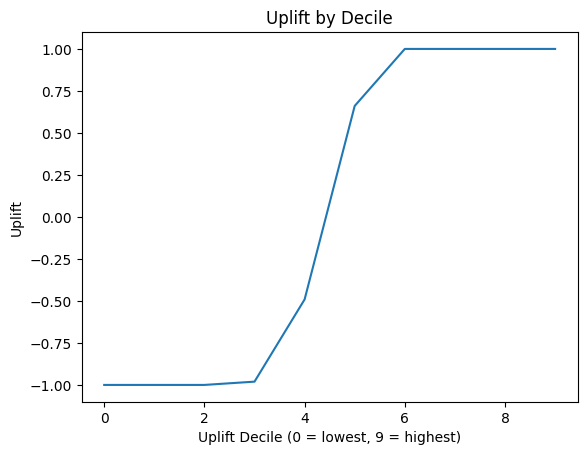

In [28]:
import matplotlib.pyplot as plt

plt.plot(uplift_df["decile"], uplift_df["uplift"])
plt.xlabel("Uplift Decile (0 = lowest, 9 = highest)")
plt.ylabel("Uplift")
plt.title("Uplift by Decile")
plt.show()

# Qini Curve

In [29]:
df_q = customer.sort_values("uplift", ascending=False).reset_index(drop = True)

In [33]:
p = customer["treatment"].mean()

df_q["gain"] = df_q.apply(
    lambda row: row["conversion"] / p if row["treatment"] == 1 else -row["conversion"] / (1-p),
    axis = 1
)

In [35]:
df_q["cumulative_gain"] = df_q["gain"].cumsum()

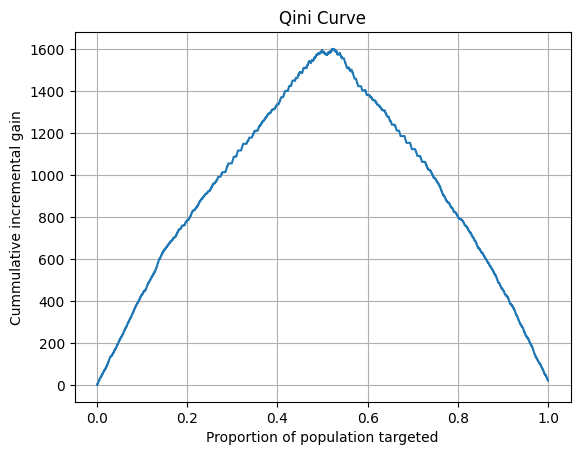

In [36]:
plt.plot(df_q.index / len(df_q), df_q["cumulative_gain"])
plt.xlabel("Proportion of population targeted")
plt.ylabel("Cummulative incremental gain")
plt.title("Qini Curve")
plt.grid(True)
plt.show()